# Ciência de Dados Aplicada a Bíblia

Nesta rápida análise, serão apresentadas estatísticas iniciais a respeito do texto total da Bíblia. O propósito desta análise foi atender a um evento, cujo objetivo foi em 10 minutos apresentar a profissão de cientista de dados, com uma aplicação bíblica. A apresentação está disponível no arquivo `Apresentação - Culto 1° de maio - Toledo.pptx`.

Para construir a apresentação, foi usado este notebook, que fica de referência para quem mais se interessar pelo assunto, servindo também como ponto de partida. É possível aprofundar a análise muito mais.

## Fonte de dados

A Bíblia possui diversas versões de escrita diferentes, porém a escolhida neste trabalho foi a versão Almeida Revista e Corrigida, pela familiaridade existente. O texto foi obtido do blog Um Só Corpo, e pode ser baixado [por aqui](https://umsocorpo.com.br/downloads/biblia-sagrada-em-txt-versao-revista-e-corrigida/).

## Análises escolhidas

Objetivou-se a construção de análises simples, agrupadas da seguinte forma:

- Quantitativas: informações tabuladas sobre número total de testamentos, livros, capítulos, versículos, e palavras;
- Ranqueamento, especificamente:
  - Livros com mais capítulos;
  - Livros com mais versos;
  - Livros mais longos (com mais palavras);
  - Maiores capítulos, considerando número de versos;
  - Maiores capítulos, considerando número de palavras;
- Ranqueamento usando gráficos de barras;
- Análise gráfica de palavras: usando gráfico de barras, "Treemap", círculos e mapa de palavras.

A seguir será apresentada a configuração inicial do ambiente, limpeza prévia do arquivo de texto contendo a Bíblia, e os métodos e resultados de cada análise.

## Configuração inicial

Antes de mostrar as análises, as importações de bibliotecas acontecem. A instalação de cada uma pode ser feita com base no arquivo `requirements.txt`. É recomendado usar um [ambiente virtual](https://docs.python.org/3/library/venv.html).


In [2]:
from collections import Counter
import string
import re
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import circlify
from wordcloud import WordCloud

nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /home/lucas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Limpeza e processamento

O arquivo original, como baixado da fonte, está em `biblia-em-txt.txt`. Para facilitar o processo de limpeza, um pré-processamento manual foi aplicado, removendo linhas vazias, o cabeçalho com título e outras informações desnecessárias, bem como pequenas correções de numeração de versículos, com resultado final disponibilizado em `preprocessado.txt`.

A partir deste último, tem início o processamento do arquivo de texto contendo a Bíblia. Para tanto, _regex_ foi usado para identificação de livros, capítulos e versículos. A lógica usada para cada um foi:

- Livros começam e terminam sempre com letras maíusculas;
- Capítulos começam com espaço, são escritos em maiúsculo e terminam com dígitos;
- Versículos sempre começam com dígitos.


In [3]:
# regras regex para identificação de hierarquia
r_livro = r"^[A-ZÀ-ÿ\s]+$"
r_capitulo = r"^\s[A-ZÀ-ÿ\s]+\s\d+$"
r_versiculo = r"^\d.*"

Com as regras definidas, pode-se abrir o arquivo e separar livros, capítulos e versículos (hierarquia) observando linha a linha:


In [4]:
linhas = open("preprocessado.txt", "r", encoding="utf-8").readlines()

livros = []
capitulos = []
versiculos = []
none = []

ultimo_livro = ""
ultimo_capitulo = ""
testamento = "VELHO"

for i, linha in enumerate(linhas):
    if re.search(r_livro, linha):
        ultimo_livro = linha
        if ultimo_livro[:-1] == "MATEUS":
            testamento = "NOVO"

        livros.append({"testamento": testamento, "livro": linha[:-1], "posicao": i})
    elif re.search(r_capitulo, linha):
        capitulos.append(
            {"livro": ultimo_livro[:-1], "capitulo": linha.split()[-1], "posicao": i}
        )
        ultimo_capitulo = linha.split()[-1]
    elif re.search(r_versiculo, linha):
        versiculos.append(
            {
                "testamento": testamento,
                "livro": ultimo_livro[:-1],
                "capitulo": ultimo_capitulo,
                "versiculo": linha.split()[0],
                "verso": linha[2:-1],
                "posicao": i,
            }
        )
    else:
        none.append({"item": linha, "posicao": i})

Durante o processamento, se alguma das linhas não se encaixa nas regras _regex_, a mesma é salva na variável `none`. Ao ver seu conteúdo, o objetivo é que esteja vazia.


In [5]:
pd.DataFrame(none).empty

True

Contando os livros por testamentos, tem-se a primeira validação de que o processamento correu como esperado, pois é sabido que o Velho Testamento da Bíblia é composto por 39 livros, enquanto que o Novo Testamento tem 27.

In [6]:
Counter(pd.DataFrame(livros)["testamento"]).most_common()

[('VELHO', 39), ('NOVO', 27)]

Os versículos bíblicos, na forma em que estão, precisam de mais uma fase de processamento para remoção de sinais de pontuação, padronização (todas letras maiúsculas) e remoção de "palavras de parada", que são palavras desnecessárias na formação de contexto e que podem atrapalhar em tarefas de análise textual.

Ao final desse processo, tem-se um *DataFrame* completo, com uma linha por versículo, contendo informação sobre o testamento, livro, capítulo e número de versículo em que está localizado na Bíblia.

In [7]:
stopwords = nltk.corpus.stopwords.words("portuguese")
versiculos_limpo = []

for verso in versiculos:
    punctuations = string.punctuation.replace("-", "")
    linha = verso["verso"].translate(str.maketrans("", "", punctuations))
    linha = " ".join([palavra.upper() for palavra in linha.split()])
    linha = " ".join(
        [palavra for palavra in linha.split() if palavra.lower() not in stopwords]
    )

    versiculos_limpo.append(linha)

versiculos_df = pd.DataFrame(versiculos)
versiculos_df["verso_limpo"] = versiculos_limpo
versiculos_df

,testamento,livro,capitulo,versiculo,verso,posicao,verso_limpo
0,VELHO,GÊNESIS,1,1,No princípio criou Deus os céus e a terra.,2,PRINCÍPIO CRIOU DEUS CÉUS TERRA
1,VELHO,GÊNESIS,1,2,A terra era sem forma e vazia; e havia trevas ...,3,TERRA FORMA VAZIA HAVIA TREVAS SOBRE FACE ABIS...
2,VELHO,GÊNESIS,1,3,Disse Deus: haja luz. E houve luz.,4,DISSE DEUS LUZ LUZ
3,VELHO,GÊNESIS,1,4,Viu Deus que a luz era boa; e fez separação en...,5,VIU DEUS LUZ BOA FEZ SEPARAÇÃO LUZ TREVAS
4,VELHO,GÊNESIS,1,5,"E Deus chamou à luz dia, e às trevas noite. E ...",6,DEUS CHAMOU LUZ DIA TREVAS NOITE TARDE MANHÃ D...
...,...,...,...,...,...,...,...
31091,NOVO,APOCALIPSE,22,17,E o Espírito e a noiva dizem: Vem. E quem ouv...,32346,ESPÍRITO NOIVA DIZEM VEM OUVE DIGA VEM SEDE VE...
31092,NOVO,APOCALIPSE,22,18,Eu testifico a todo aquele que ouvir as palav...,32347,TESTIFICO TODO OUVIR PALAVRAS PROFECIA DESTE L...
31093,NOVO,APOCALIPSE,22,19,e se alguém tirar qualquer coisa das palavras...,32348,ALGUÉM TIRAR QUALQUER COISA PALAVRAS LIVRO DES...
31094,NOVO,APOCALIPSE,22,20,Aquele que testifica estas coisas diz: Certam...,32349,TESTIFICA COISAS DIZ CERTAMENTE CEDO VENHO AMÉ...


O resultado pode ser salvo em arquivo CSV para facilitar análises externas a este notebook:

In [8]:
versiculos_df.to_csv("processado.csv")

## Análise quantitativa

Agora, pode-se mostrar a contagem total de testamentos, livros, capítulos, versículos e palavras existentes na Bíblia.


In [9]:
total_testamentos = len(versiculos_df[["testamento"]].drop_duplicates())
total_livros = len(versiculos_df[["livro"]].drop_duplicates())
total_capitulos = len(versiculos_df[["livro", "capitulo"]].drop_duplicates())
total_versiculos = len(
    versiculos_df[["livro", "capitulo", "versiculo"]].drop_duplicates()
)

grande_string = ""
for linha in versiculos_limpo:
    grande_string += linha + " "

grande_lista = grande_string.split()

print(f"Testamentos: {total_testamentos}")
print(f"Livros: {total_livros}")
print(f"Capítulos: {total_capitulos}")
print(f"Versículos: {total_versiculos}")
print(f"Palavras: {len(grande_lista)}")

Testamentos: 2
Livros: 66
Capítulos: 1189
Versículos: 31096
Palavras: 358209


Para facilitar análises posteriores, a quantidade de palavras de cada verso limpo (processado) é salva em coluna própria no DataFrame.

In [10]:
num_palavras = []
for verso in versiculos_df.to_dict(orient="records"):
    num_palavras.append(len(verso["verso_limpo"].split()))

versiculos_df["tam_verso_limpo"] = num_palavras
versiculos_df

,testamento,livro,capitulo,versiculo,verso,posicao,verso_limpo,tam_verso_limpo
0,VELHO,GÊNESIS,1,1,No princípio criou Deus os céus e a terra.,2,PRINCÍPIO CRIOU DEUS CÉUS TERRA,5
1,VELHO,GÊNESIS,1,2,A terra era sem forma e vazia; e havia trevas ...,3,TERRA FORMA VAZIA HAVIA TREVAS SOBRE FACE ABIS...,14
2,VELHO,GÊNESIS,1,3,Disse Deus: haja luz. E houve luz.,4,DISSE DEUS LUZ LUZ,4
3,VELHO,GÊNESIS,1,4,Viu Deus que a luz era boa; e fez separação en...,5,VIU DEUS LUZ BOA FEZ SEPARAÇÃO LUZ TREVAS,8
4,VELHO,GÊNESIS,1,5,"E Deus chamou à luz dia, e às trevas noite. E ...",6,DEUS CHAMOU LUZ DIA TREVAS NOITE TARDE MANHÃ D...,10
...,...,...,...,...,...,...,...,...
31091,NOVO,APOCALIPSE,22,17,E o Espírito e a noiva dizem: Vem. E quem ouv...,32346,ESPÍRITO NOIVA DIZEM VEM OUVE DIGA VEM SEDE VE...,14
31092,NOVO,APOCALIPSE,22,18,Eu testifico a todo aquele que ouvir as palav...,32347,TESTIFICO TODO OUVIR PALAVRAS PROFECIA DESTE L...,17
31093,NOVO,APOCALIPSE,22,19,e se alguém tirar qualquer coisa das palavras...,32348,ALGUÉM TIRAR QUALQUER COISA PALAVRAS LIVRO DES...,18
31094,NOVO,APOCALIPSE,22,20,Aquele que testifica estas coisas diz: Certam...,32349,TESTIFICA COISAS DIZ CERTAMENTE CEDO VENHO AMÉ...,10


## Análise de ranqueamento

Conhecendo o quantitativos geral da Bíblia, é interessante ranquear por hierarquia. A seguir, cada ranqueamento por hierarquia é feito, considerando apenas os TOP 10 de cada.


In [11]:
# Livros com mais capítulos;
top_livros_caps = Counter(
    versiculos_df[["livro", "capitulo"]].drop_duplicates()["livro"]
).most_common(10)

# Livros com mais versos;
top_livros_vers = Counter(versiculos_df["livro"]).most_common(10)

# Livros mais longos (com mais palavras);
top_livros_palav = (
    versiculos_df[["livro", "tam_verso_limpo"]]
    .groupby("livro")
    .sum()
    .sort_values(by="tam_verso_limpo", ascending=False)
    .head(10)
)

# Maiores capítulos (número de versos);
top_capitulos_vers = (
    versiculos_df[["livro", "capitulo", "versiculo"]]
    .groupby(["capitulo", "livro"])
    .count()
    .sort_values(by="versiculo", ascending=False)
    .head(10)
)

# Maiores capítulos (número de palavras);
top_capitulos_palav = (
    versiculos_df[["livro", "capitulo", "tam_verso_limpo"]]
    .groupby(["capitulo", "livro"])
    .sum()
    .sort_values(by="tam_verso_limpo", ascending=False)
    .head(10)
)

# Maiores versos (número de palavras);
top_versos = versiculos_df.sort_values(by="tam_verso_limpo", ascending=False).head(10)[
    ["livro", "capitulo", "versiculo", "verso", "tam_verso_limpo"]
]

Pode-se usar a célula a seguir para consultar cada ranqueamento. Por exemplo, é mostrado o ranqueamento de maiores capítulos por número de palavras:

In [12]:
top_capitulos_palav

,,tam_verso_limpo
capitulo,livro,
119,SALMOS,1153
8,I REIS,985
7,NÚMEROS,978
28,DEUTERONÔMIO,857
51,JEREMIAS,849
16,EZEQUIEL,796
24,GÊNESIS,794
17,I SAMUEL,785
9,JUÍZES,762


É possível concluir que o capítulo 119 de Salmos (ou "salmo 119") é o que contém mais palavras em toda a Bíblia, seguido de I Reis 8 e Números 7. 

## Análise de ranquemanto usando gráficos

Embora seja possível tirar conclusões sobre todos os ranqueamentos com base nos resultados tabulados, a análise gráfica facilita a percepção e ajuda no entendimento dos dados.

A seguir, três ranqueamentos são ilustrados com gráficos de barras: livros com mais capítulos, versículos e palavras.


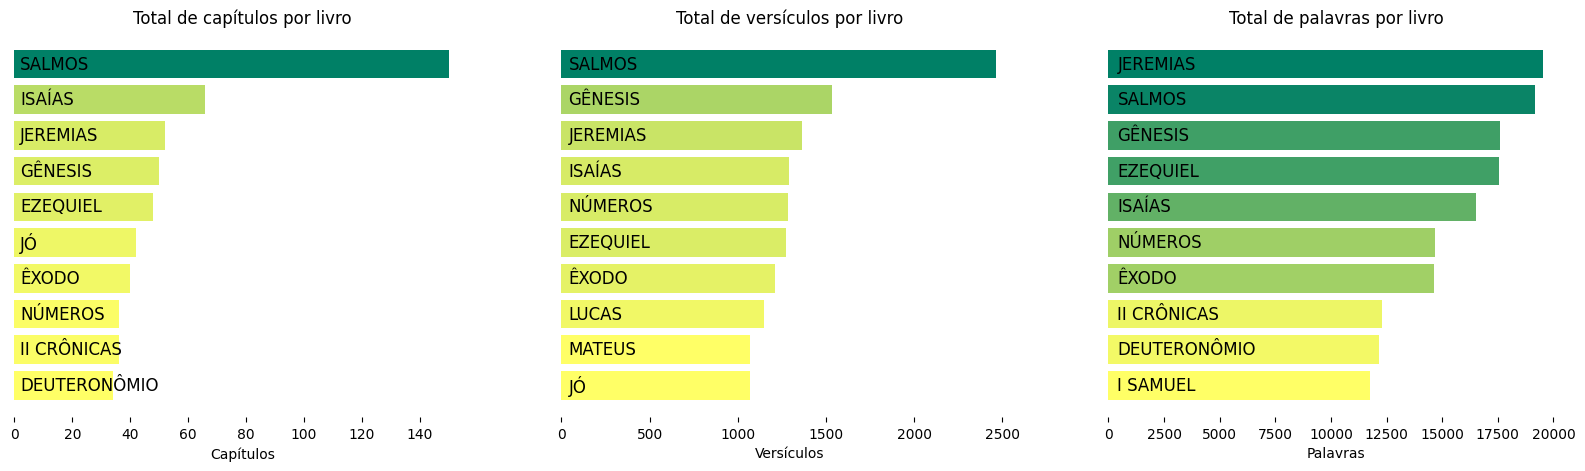

In [13]:
# Separação de labels e quantidades
_livros_caps = [livro[0] for livro in top_livros_caps]
_livros_vers = [livro[0] for livro in top_livros_vers]
_livros_palav = top_livros_palav.index
_caps = [livro[1] for livro in top_livros_caps]
_vers = [livro[1] for livro in top_livros_vers]
_palav = top_livros_palav["tam_verso_limpo"]

# Criação da figura
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

my_cmap = plt.get_cmap("summer_r")
rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))

# Livros com mais capítulos
ax[0].barh(_livros_caps, _caps, color=my_cmap(rescale(_caps)))
ax[0].invert_yaxis()
for i, p in enumerate(_livros_caps):
    ax[0].text(s=p, x=2, y=i, color="black", verticalalignment="center", size=12)
ax[0].yaxis.set_visible(False)
ax[0].spines[["top", "right", "bottom", "left"]].set_visible(False)
ax[0].set_xlabel("Capítulos")
ax[0].set_title("Total de capítulos por livro")

# Livros com mais versículos
ax[1].barh(_livros_vers, _vers, color=my_cmap(rescale(_vers)))
ax[1].invert_yaxis()
for i, p in enumerate(_livros_vers):
    ax[1].text(s=p, x=40, y=i, color="black", verticalalignment="center", size=12)
ax[1].yaxis.set_visible(False)
ax[1].spines[["top", "right", "bottom", "left"]].set_visible(False)
ax[1].set_xlabel("Versículos")
ax[1].set_title("Total de versículos por livro")

# Livros mais longos
ax[2].barh(_livros_palav, _palav, color=my_cmap(rescale(_palav)))
ax[2].invert_yaxis()
for i, p in enumerate(_livros_palav):
    ax[2].text(s=p, x=400, y=i, color="black", verticalalignment="center", size=12)
ax[2].yaxis.set_visible(False)
ax[2].spines[["top", "right", "bottom", "left"]].set_visible(False)
ax[2].set_xlabel("Palavras")
ax[2].set_title("Total de palavras por livro")

plt.show()

Pode-se notar que, para o ranqueamento por número de capítulos, o livro dos Salmos se destaca, o que não é surpresa, já que é composto por 150 capítulos (ou salmos), seguido por Isaías e Jeremias, outros livros reconhecidamente grandes em número de capítulos. No segundo ranqueamento, Salmos permanece em primeiro, porém é interessante que Gênesis vem logo em segundo, contendo mais versículos do que Jeremias e Isaías. Por fim, ao ranquear por total de palavras, Jeremias resulta como livro mais denso, até mais do que Salmos.

## Análise de palavras

Para realizar esta análise, o texto todo da Bíblia é usado. Então todos os versículos são contatenados em uma grande *string*, que é separada palavra por palavra em um vetor. Depois, é feita a contagem de palavras, ordenada em um DataFrame.

In [14]:
grande_string = ""
for linha in versiculos_limpo:
    grande_string += linha + " "

list_words = grande_string.split(" ")
set_words_full = list(set(list_words))
count_words = [list_words.count(i) for i in set_words_full]

contagem_palav = pd.DataFrame(
    zip(set_words_full, count_words), columns=["palavra", "contagem"]
)
contagem_palav = contagem_palav.sort_values("contagem", ascending=False)
contagem_palav

,palavra,contagem
13497,SENHOR,8017
18817,DEUS,4417
13876,POIS,3382
26318,TERRA,2936
8626,FILHOS,2781
...,...,...
17808,DERRUBANDO,1
17810,NAARÃ,1
17811,CIRCUNDA,1
17812,GRANADAS,1


O ranqueamento de palavras mais comuns pode ser visualizado como os ranqueamentos anteriores, por meio de um gráfico de barras.

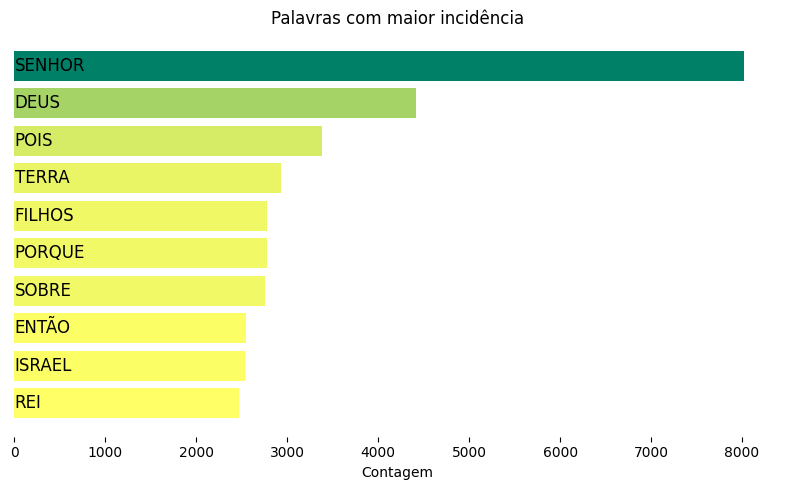

In [15]:
fig, ax = plt.subplots(figsize=(8, 5))

_palavras = contagem_palav.head(10)["palavra"]
_palavras_cont = contagem_palav.head(10)["contagem"]

ax.barh(_palavras, _palavras_cont, color=my_cmap(rescale(_palavras_cont)))
ax.invert_yaxis()
for i, p in enumerate(_palavras):
    ax.text(s=p, x=2, y=i, color="black", verticalalignment="center", size=12)
ax.yaxis.set_visible(False)
ax.spines[["top", "right", "bottom", "left"]].set_visible(False)
ax.set_xlabel("Contagem")
ax.set_title("Palavras com maior incidência")

plt.tight_layout()
plt.show()

Percebe-se que a palavra "Senhor" é a mais presente em toda a Bíbila, muitas vezes usada para referenciar a figura de Deus em ambos os testamentos. Em seguida, "Deus" aparece como a segunda palavra mais comum. Faz sentido, uma vez que esse pode ser considerado um dos temas principais da Bíblia.

Não obstante, existem outras formas de visualizar a mesma informação, como por meio de "treemaps", círculos e mapa de palavras.

### Treemap

In [19]:
fig = px.treemap(
    contagem_palav[0:50],
    path=[px.Constant("Bíblia"), "palavra"],
    values="contagem",
    color="contagem",
    color_continuous_scale="tempo",
)

fig.update_layout(margin=dict(t=5, l=5, r=5, b=5))
fig.show()

A visualização com "Treemap" permite ver a mesma informação que o gráfico de barras, porém pode-se observar uma maior quantidade de palavras em espaço similar.

### Círculos

In [20]:
def get_colordict(palette, number, start):
    pal = list(sns.color_palette(palette=palette, n_colors=number).as_hex())
    color_d = dict(enumerate(pal, start=start))
    return color_d

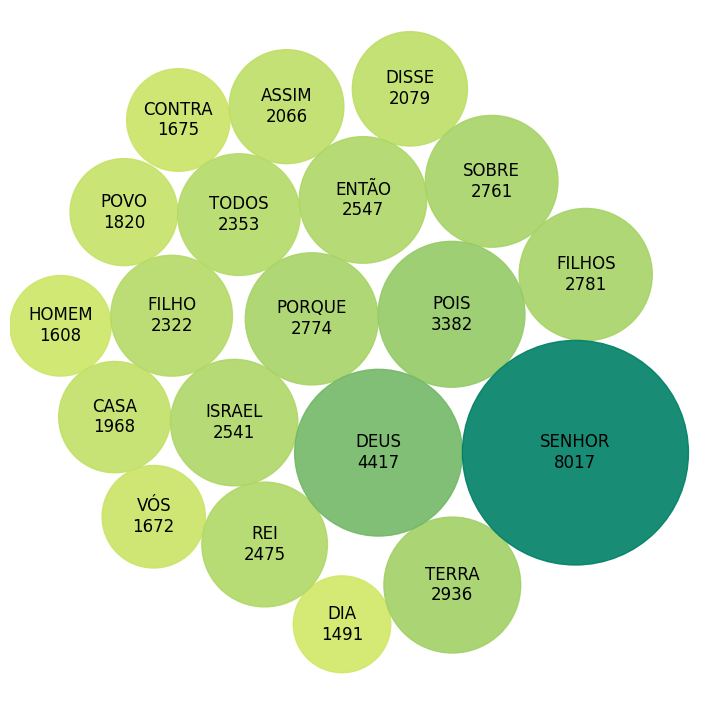

In [21]:
# Computar posição dos círculos:
circles = circlify.circlify(
    contagem_palav["contagem"][0:20].tolist(),
    show_enclosure=False,
    target_enclosure=circlify.Circle(x=0, y=0),
)

n = contagem_palav["contagem"][0:20].max()
color_dict = get_colordict("summer_r", n, 1)

fig, ax = plt.subplots(figsize=(9, 9), facecolor="white")
ax.axis("off")
lim = max(
    max(
        abs(circle.x) + circle.r,
        abs(circle.y) + circle.r,
    )
    for circle in circles
)
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)

# Lista de labels
labels = list(contagem_palav["palavra"][0:20])
counts = list(contagem_palav["contagem"][0:20])
labels.reverse()
counts.reverse()

# Print circles
for circle, label, count in zip(circles, labels, counts):
    x, y, r = circle
    ax.add_patch(plt.Circle((x, y), r, alpha=0.9, color=color_dict.get(count)))
    plt.annotate(label + "\n" + str(count), (x, y), size=12, va="center", ha="center")
plt.xticks([])
plt.yticks([])
plt.show()

Com variação de tamanho e cor, essa forma de representação também é interessante, muito embora para valores próximos seja mais difícil de perceber a ordem do ranqueamento.

### Mapa de palavras

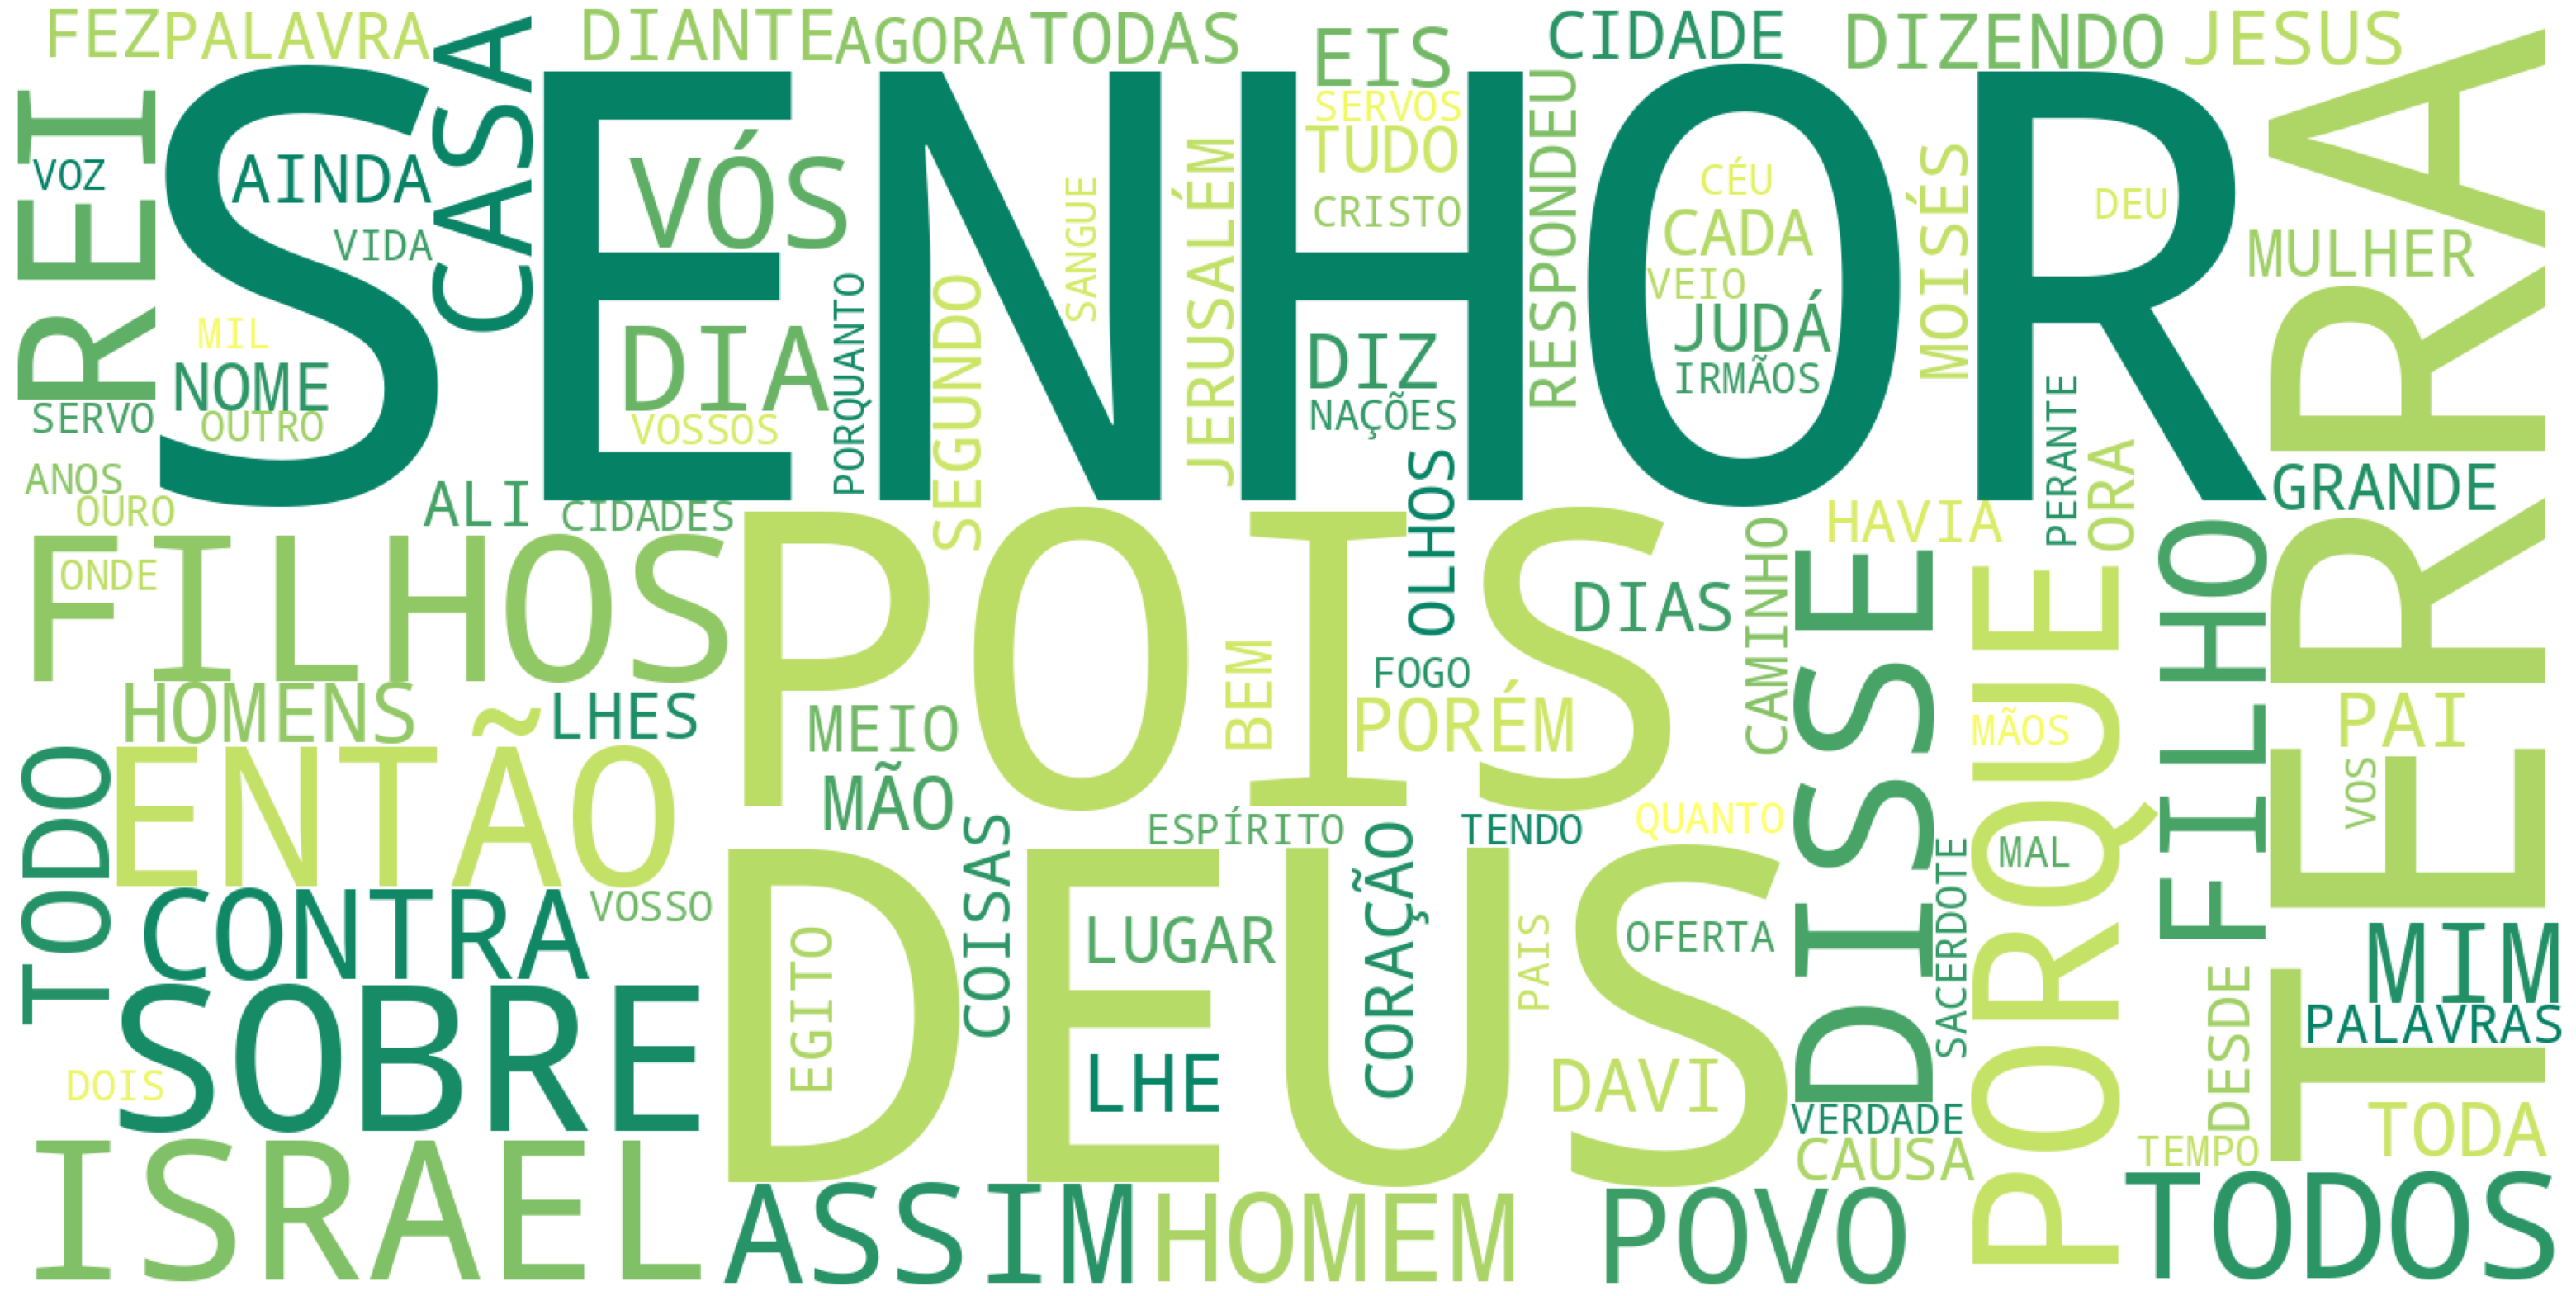

In [22]:
wordcloud = WordCloud(
    width=1600,
    height=800,
    background_color="white",
    min_word_length=3,
    max_words=100,
    collocations=False,
    normalize_plurals=False,
    colormap="summer",
).generate(grande_string)
plt.figure(figsize=(40, 30))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

Essa forma é muito mais artística e visualmente apelativa, colocando as palavras em um espaço limitado, sendo que o seu tamanho indica a frequência com que aparecem no texto.

## Conclusão

Todas as análises anteriores podem ser adaptadas, pensando em aspectos mais pontuais, como por exemplo observar apenas os livros do Novo Testamento, ou somente os Evangelhos, ou ainda um livro, apenas. Por exemplo, o mapa de palavras a seguir considera somente as palavras usadas no livro de Cantares de Salomão.

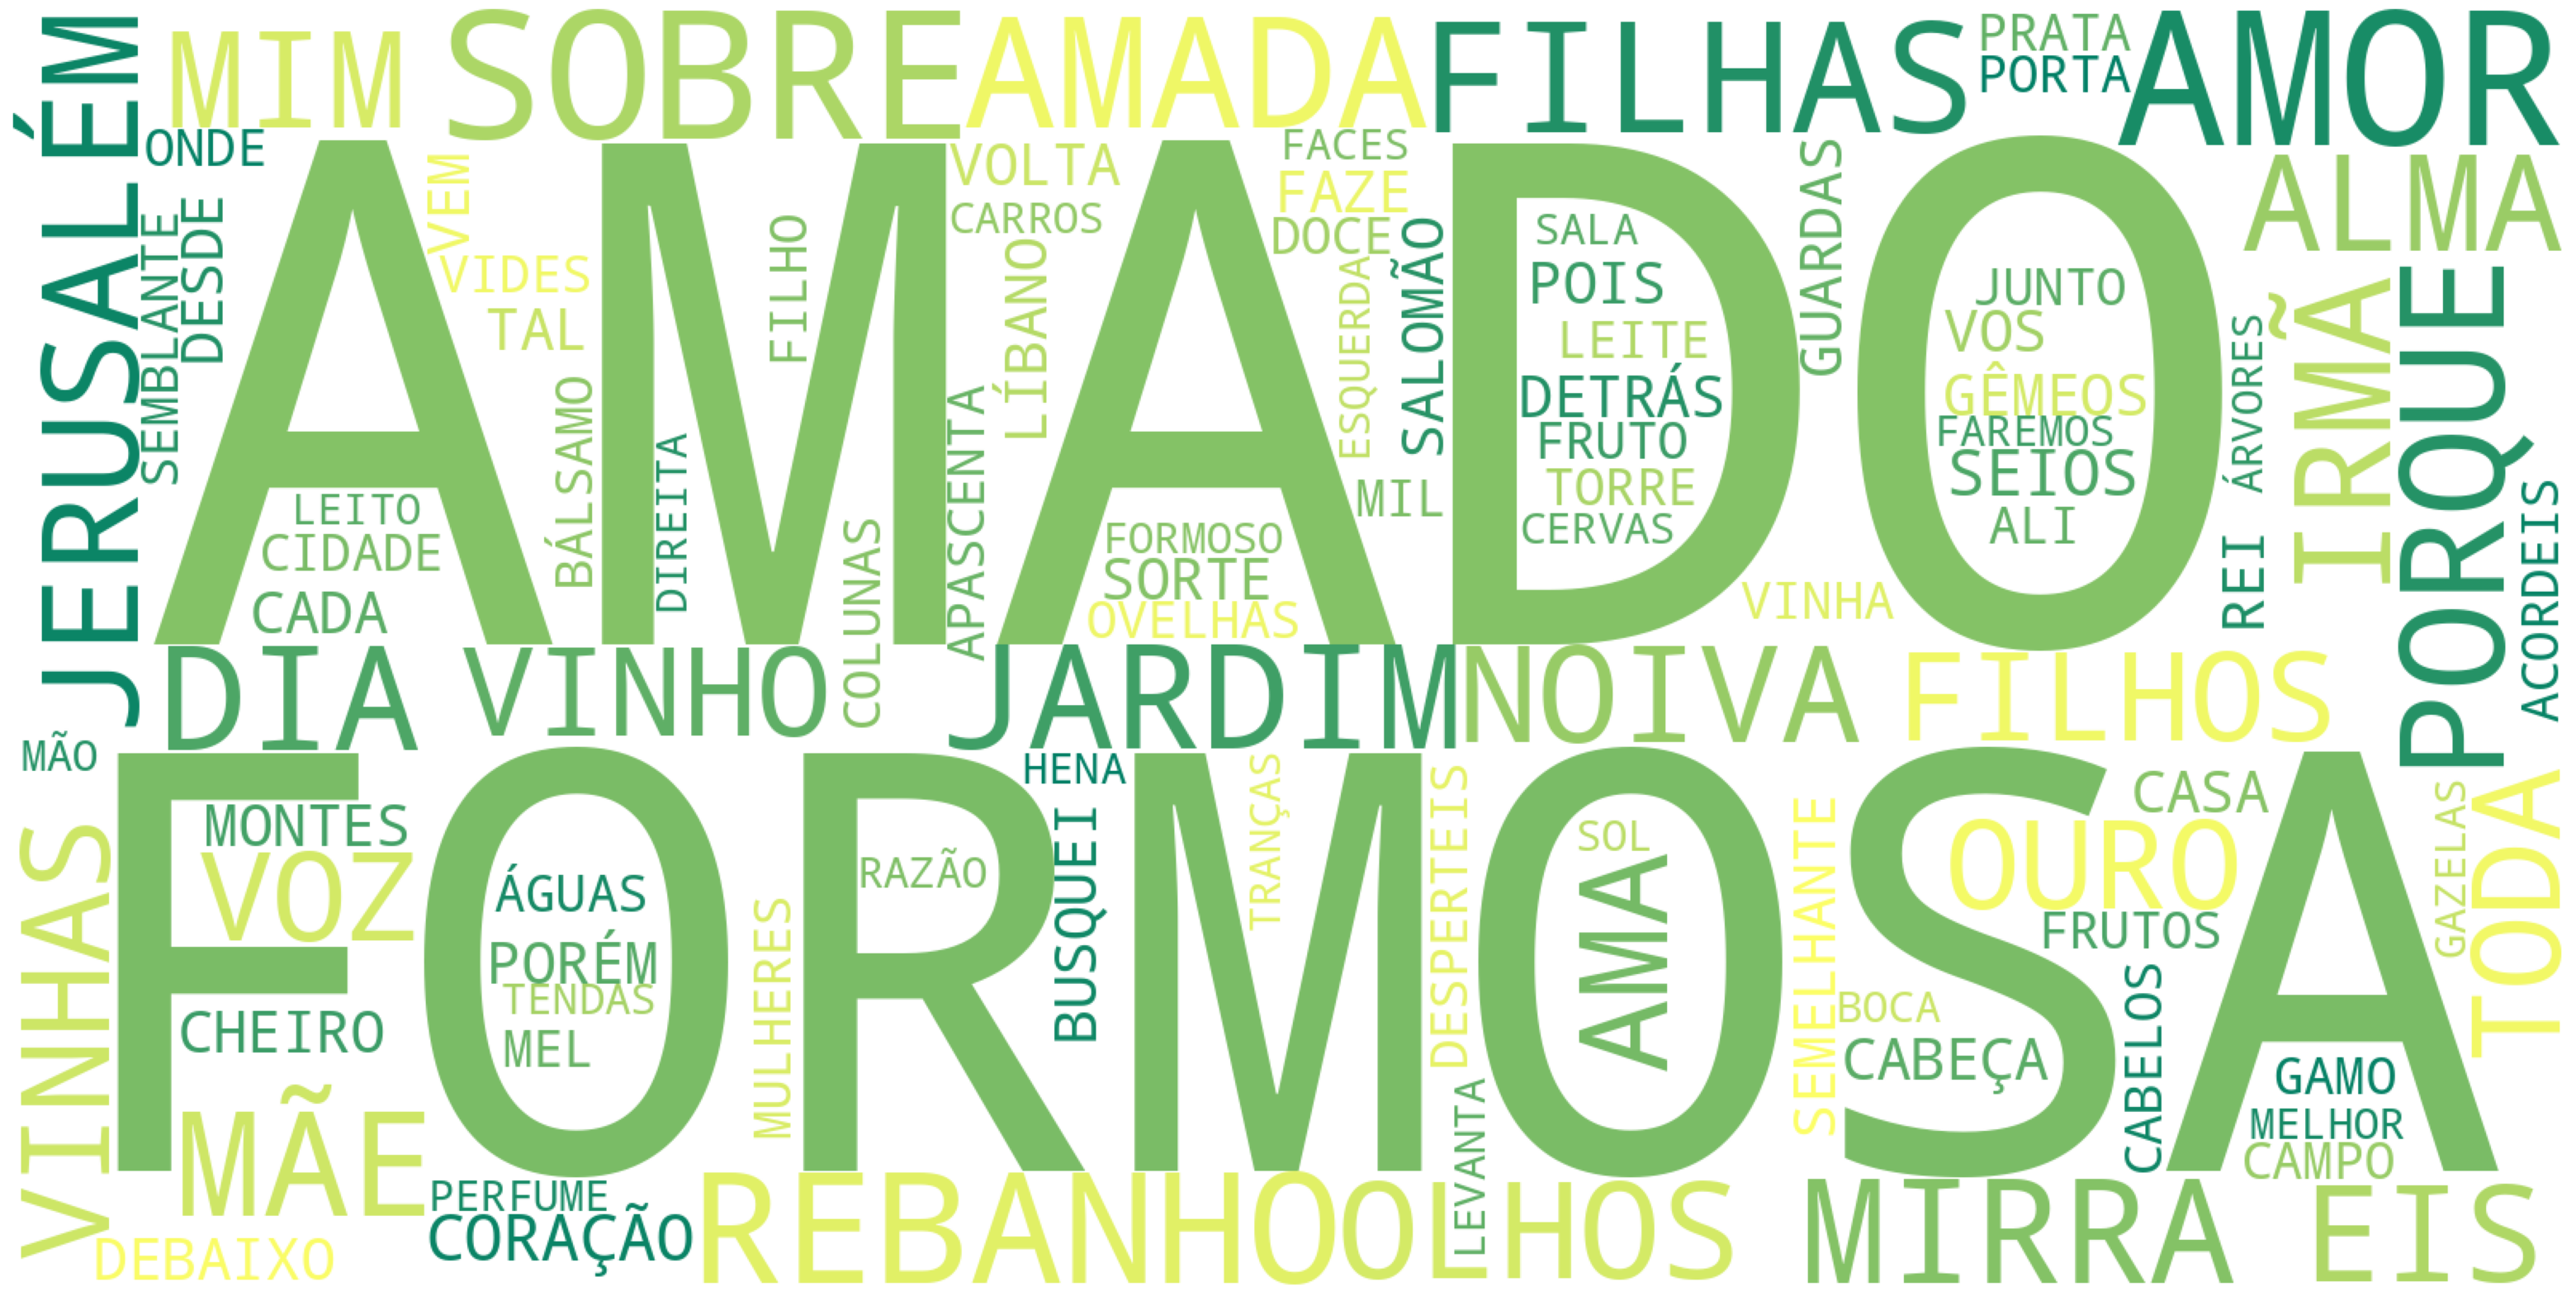

In [23]:
cantares_df = versiculos_df[versiculos_df["livro"] == "CÂNTICO DOS CÂNTICOS"]

cantares_string = ""
for verso in cantares_df.to_dict(orient="records"):
    cantares_string += verso["verso_limpo"]


wordcloud_cantares = WordCloud(
    width=1600,
    height=800,
    background_color="white",
    min_word_length=3,
    max_words=100,
    collocations=False,
    normalize_plurals=False,
    colormap="summer",
).generate(cantares_string)
plt.figure(figsize=(40, 30))
plt.imshow(wordcloud_cantares)
plt.axis("off")
plt.show()

É notável a quantidade de informação que pode-se obter de análises tão simples. E as ideias de análises mais profundas ou alternativas são das mais variadas.

Este estudo teve como objetivo servir de ponto de partida, provendo material e ideias, para que estudantes e entusiastas continuem a analisar este texto que é tão rico, não só de forma lógica e racional, mas também moral, ético e de fé.

## Referências

- [The Bible under the NLP eye (Part 1)](https://towardsdatascience.com/the-bible-under-the-nlp-eye-part-1-416dbfd79444).
